# カメラの位置姿勢を求める

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skvideo.io import vread
import moviepy.editor as mpy
from tqdm import tqdm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image


def npy_to_gif(npy, filename):
    clip = mpy.ImageSequenceClip(list(npy), fps=10)
    clip.write_gif(filename)

### 1. 素材

In [2]:
vid = vread("src/shisa.mp4")
print(vid.shape)

(524, 1920, 1080, 3)


### 2. アルコマーカー

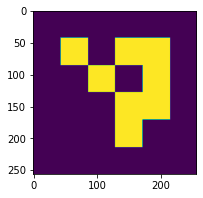

In [3]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco = cv2.aruco.drawMarker(aruco_dict, 0, 256)
plt.figure(figsize=(3,3)); plt.imshow(aruco); plt.show()
# cv2.imwrite("aruco.png", aruco)

### 3. カメラの設定

In [4]:
marker_length = 0.07 # [m] ### 注意！
mtx = np.load("camera/mtx.npy")
dist = np.load("camera/dist.npy")
print(mtx); print(dist)

[[1.83882882e+03 0.00000000e+00 5.20791172e+02]
 [0.00000000e+00 1.82803295e+03 9.76365659e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 2.97906356e-01 -4.84831541e-01  4.55397225e-03  8.49742572e-04
  -1.61521682e+00]]


### 4. マーカーの検出

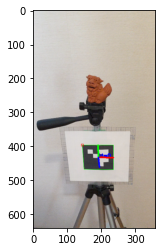

In [5]:
frame = vid[0]
frame = frame[...,::-1]  # BGR2RGB
frame = cv2.resize(frame, (360, 640))

corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)
rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, mtx, dist)

# ---- 描画
frame = cv2.aruco.drawDetectedMarkers(frame, corners, ids)
frame = cv2.aruco.drawAxis(frame, mtx, dist, rvec, tvec, marker_length/2)
# ----

plt.imshow(frame[...,::-1]); plt.show()

### 5. カメラの位置姿勢の計算

In [6]:
xyz = []
rpy = []
uvw_x = []
uvw_y = []
uvw_z = []

for frame in vid[:500:25]:  # 全部処理すると重いので…
    frame = frame[...,::-1]  # BGR2RGB
    frame = cv2.resize(frame, (360, 640))
    corners, ids, _ = cv2.aruco.detectMarkers(frame, aruco_dict)

    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, mtx, dist)

    R_T = cv2.Rodrigues(rvec)[0].T  # 回転ベクトル -> 回転行列
    T = tvec[0].T
    xyz.append(np.dot(R_T, - T).squeeze())

    r = np.arctan2(-R_T[2][1], R_T[2][2])
    p = np.arcsin(R_T[2][0])
    y = np.arctan2(-R_T[1][0], R_T[0][0])
    rpy.append(- np.array([r, p, y]))

    uvw_x.append( - np.dot(R_T, np.array([0,0,-1])))
    uvw_y.append( - np.dot(R_T, np.array([1,0,0])))
    uvw_z.append( - np.dot(R_T, np.array([0,1,0])))

    # ---- 描画
    cv2.aruco.drawDetectedMarkers(frame, corners, ids, (0,255,255))
    cv2.aruco.drawAxis(frame, mtx, dist, rvec, tvec, marker_length/2)
    cv2.imshow('frame', frame)
    cv2.waitKey(1)
    # ----

cv2.destroyAllWindows()

In [7]:
def plot_all_frames(elev=90, azim=270):
    frames = []

    for t in tqdm(range(len(xyz))):
        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2); ax.set_zlim(-2, 2)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        x, y, z = xyz[t]
        ux, vx, wx = uvw_x[t]
        uy, vy, wy = uvw_y[t]
        uz, vz, wz = uvw_z[t]

        # draw marker
        ax.scatter(0,0,0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        if t < 5:
            ax.quiver(x, y, z, ux, vx, wx, length=0.5, color="k")
            ax.quiver(x, y, z, uy, vy, wy, length=0.5, color="k")
            ax.quiver(x, y, z, uz, vz, wz, length=0.5, color="k")
        else:
            ax.quiver(x, y, z, ux, vx, wx, length=0.5, color="r")
            ax.quiver(x, y, z, uy, vy, wy, length=0.5, color="g")
            ax.quiver(x, y, z, uz, vz, wz, length=0.5, color="b")

        # save for animation
        fig.canvas.draw()
        frames.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [8]:
frames = plot_all_frames(elev=105, azim=270)
npy_to_gif(frames, "src/sample1.gif"); Image(url='src/sample1.gif')

t:  33%|███▎      | 7/21 [00:00<00:00, 64.82it/s, now=None]

MoviePy - Building file src/sample1.gif with imageio.


In [9]:
frames = plot_all_frames(elev=165, azim=270)
npy_to_gif(frames, "src/sample2.gif"); Image(url='src/sample2.gif')

t:  38%|███▊      | 8/21 [00:00<00:00, 73.86it/s, now=None]

MoviePy - Building file src/sample2.gif with imageio.


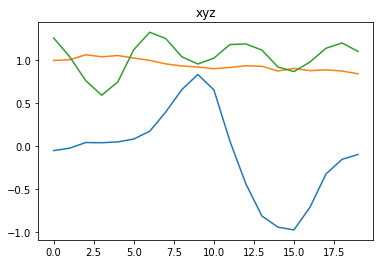

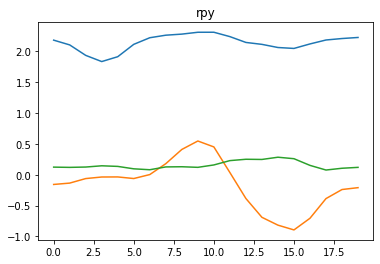

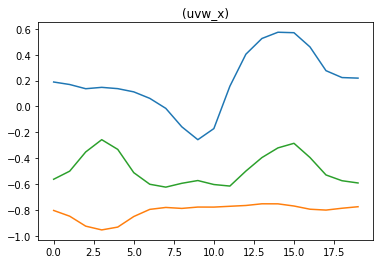

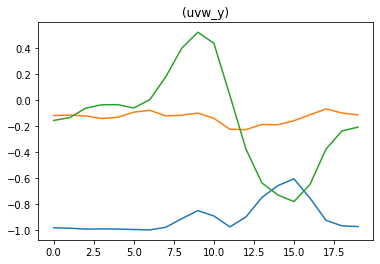

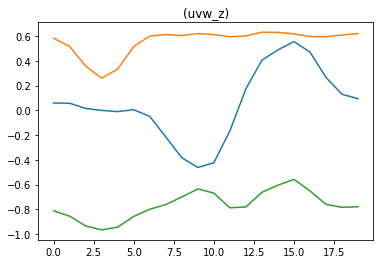

In [10]:
plt.title("xyz"); plt.plot(xyz); plt.show()  # 青:x, 橙:y, 緑:z
plt.title("rpy"); plt.plot(rpy); plt.show()  # 青:r, 橙:p, 緑:y
plt.title("(uvw_x)"); plt.plot(uvw_x); plt.show()
plt.title("(uvw_y)"); plt.plot(uvw_y); plt.show()
plt.title("(uvw_z)"); plt.plot(uvw_z); plt.show()